<a href="https://colab.research.google.com/github/VishwajithP2308/cs666student/blob/main/Copy_of_Copy_of_CS666_Assignment_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

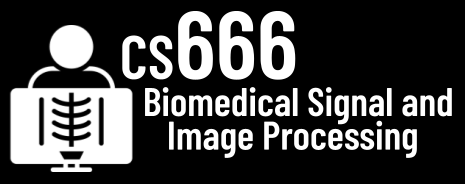
# Assignment 6

In [1]:
# NAME:Vishwajith Parushaboyena

In [2]:
# In this assignment, we will explore the new Segment-Anything-Model (https://segment-anything.com/)
# for the task of mitochondria detection in a connectomics dataset acquired using electron microscopy.
#
# We will run the following experiments:
#
# 1. Using the Segment-Anything-Model (SAM) without seeds in auto mode
#
# 2. Train a U-Net classifier from scratch
#
# 3. Evaluate the U-Net classifier
#
# 4. Use the U-Net to seed the SAM model (U-Net + SAM)
#
# 5. Compare U-Net vs. U-Net + SAM
#
# Bonus: Improve U-Net + SAM

In [3]:
### IMPORTANT (DO THIS RIGHT AWAY!) ###
#
# Activate GPU support: Runtime -> Change Runtime Type
# Hardware Accelerator: GPU
#
### IMPORTANT ###

In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
# We will use mahotas as well!
!pip install mahotas --no-binary :all:
import mahotas as mh

DEPRECATION: --no-binary currently disables reading from the cache of locally built wheels. In the future --no-binary will not influence the wheel cache. pip 23.1 will enforce this behaviour change. A possible replacement is to use the --no-cache-dir option. You can use the flag --use-feature=no-binary-enable-wheel-cache to test the upcoming behaviour. Discussion can be found at https://github.com/pypa/pip/issues/11453
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
# And of course, we need the data!
!wget https://cs666.org/data/mito.npz

--2023-04-25 02:00:46--  https://cs666.org/data/mito.npz
Resolving cs666.org (cs666.org)... 185.199.110.153, 185.199.111.153, 185.199.108.153, ...
Connecting to cs666.org (cs666.org)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37610178 (36M) [application/octet-stream]
Saving to: ‘mito.npz.1’

mito.npz.1          100%[===================>]  35.87M  --.-KB/s    in 0.1s    

2023-04-25 02:00:47 (340 MB/s) - ‘mito.npz.1’ saved [37610178/37610178]



## 0. Data loading (5 points)

In [7]:
# The data includes images and manually segmented masks.
loaded = np.load('mito.npz')
images = loaded['arr_0'][0]
masks = loaded['arr_0'][1]

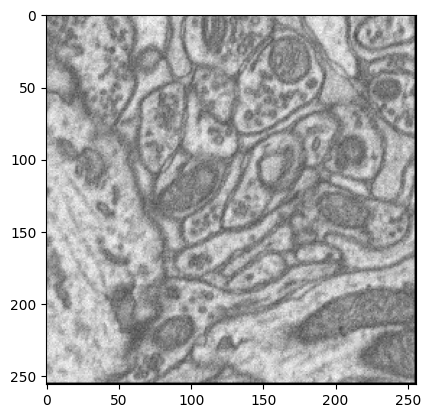

In [8]:
# TODO: Show the first image with the gray colormap.
# TODO: YOUR_CODE
imshow(images[0],cmap ="gray")

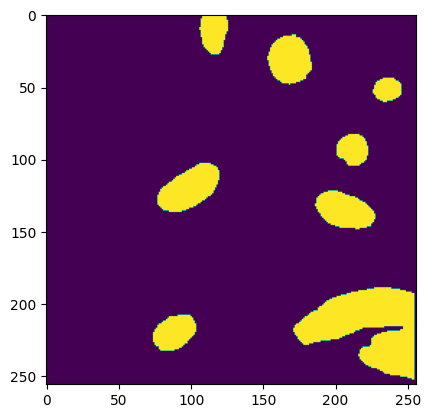

In [9]:
# TODO: Show the first mask.
imshow(masks[0])

## 1. SAM in AUTO mode (15 points)

In [10]:
# We will use the METASEG package as an easy-to-use layer
# for SAM.
!pip install metaseg==0.6.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
# SAM comes in two modes, auto and with seeds
from metaseg import SegAutoMaskPredictor, SegManualMaskPredictor

In [12]:
# SAM takes files as input!
# So we have to store the numpy array to disk.
mh.imsave('first.png', images[0])


In [13]:
#
# Run SAM in auto mode on first.png and store
# the result as first_output.png.
#
results = SegAutoMaskPredictor().image_predict(
    source="first.png",
    model_type="vit_l", # vit_l, vit_h, vit_b
    points_per_side=16, 
    points_per_batch=64,
    min_area=0,
    output_path="first_output.png",
    show=False,
    save=True,
)

vit_l model already exists as 'vit_l.pth'. Skipping download.


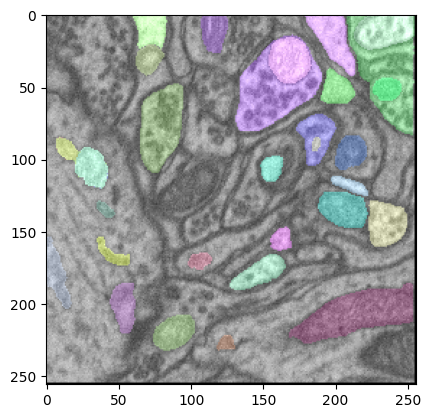

In [14]:
imshow( mh.imread('first_output.png') )


In [15]:
# TODO: Does SAM work well for mitochondria detection?
# TODO: YOUR_ANSWER


There are places where the mitochondria border detection was overstated, for instance consider the bottom left corner and there are other parts where it was incorrectly classified or perhaps not selected at all, so it doesn't look like it works especially well.

In [16]:
# TODO: Try the auto predictor on your image!
# 
# Please upload your own image and test how well
# the auto mode of SAM performs!
#
# Run SAM in auto mode on that image and store
# the result as second_output.png. Show the output!
#

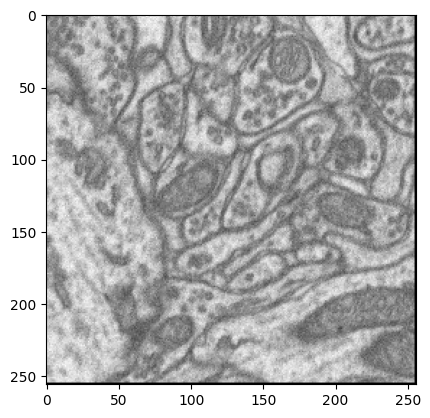

In [17]:
# TODO: YOUR CODE
mh.imsave('second_output.png', images[1])
imshow(images[1], cmap= 'gray')

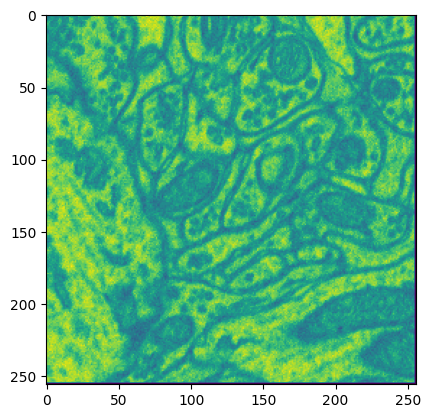

In [18]:
imshow( mh.imread('second_output.png') )


In [19]:
# TODO: Does SAM work well on your example?
# TODO: YOUR_ANSWER

It shows some good regions where the boundaries or features can be seen clearly as well as there are some parts which require some fixing.So, it works in a pretty much similar way to the first image 

## 2. Train a U-Net classifier from scratch (50 points)


In [20]:
# We will use the keras_unet package!
#
# HINT: There is documentation available here, if you are stuck during this part
# of the assignment: https://github.com/karolzak/keras-unet
!pip install keras_unet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [21]:
# keras_unet has convenience functions to visualize data
from keras_unet.utils import plot_imgs

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


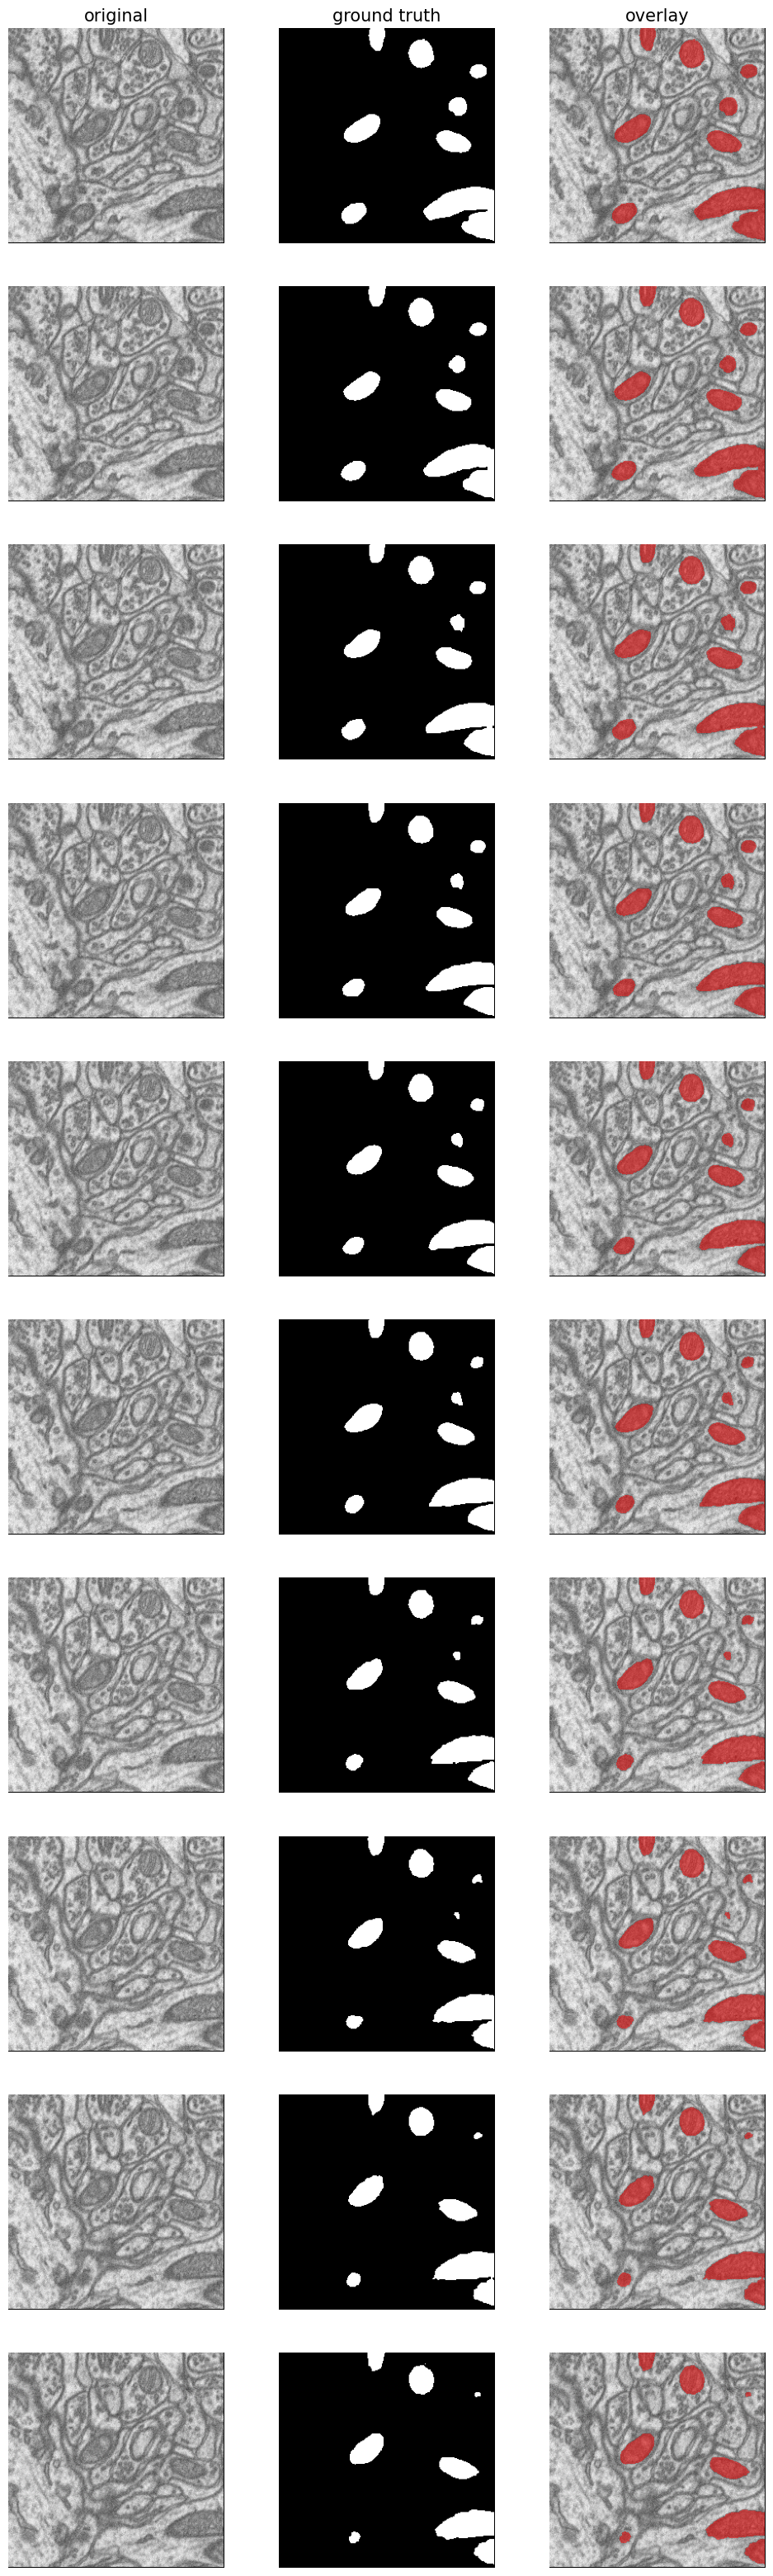

In [22]:
# Let's plot a few images and masks.
plot_imgs(org_imgs=images, mask_imgs=masks)

In [23]:
# The images are in this format.
print( images.shape, images.max(), images.dtype )

(660, 256, 256) 243 uint8


In [24]:
# TODO convert the format to the following:
# (660, 256, 256, 1) 1.0 float32
#
# 1) convert to float32
# 2) normalize to the range of 0..1
# 3) Add the last channel using .reshape like in class
# TODO: YOUR_CODE

# Converting to float32
X = images.astype(np.float32)

# Normalize to the range of 0..1
X /= 245.0

# Add the last channel
X = X.reshape((660, 256, 256, 1))



In [25]:
# Validate that everything matches accordingly
print( X.shape, X.max(), X.dtype )

(660, 256, 256, 1) 0.9918367 float32


In [26]:
# The masks are in this format.
print( masks.shape, masks.max(), masks.dtype )

(660, 256, 256) 255 uint8


In [27]:
# TODO convert the format to the following:
# (660, 256, 256, 1) True bool
#
# 1) convert to bool
# 2) Add the last channel using .reshape like in class
#
# TODO: YOUR_CODE
# y = 

# Convert to bool
y = masks.astype(np.bool)

# Adding the last channel
y = np.expand_dims(y, axis=-1)


<ipython-input-27-b3c1ec8478cd>:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = masks.astype(np.bool)


In [28]:
# Validate that everything matches accordingly
print( y.shape, y.max(), y.dtype )

(660, 256, 256, 1) True bool


In [29]:
#
# Now we will create our train/val/test splits using scikit-learn!
#
from sklearn.model_selection import train_test_split

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [31]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=0)

In [32]:
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_val: ", X_val.shape)
print("y_val: ", y_val.shape)
print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape)

X_train:  (369, 256, 256, 1)
y_train:  (369, 256, 256, 1)
X_val:  (159, 256, 256, 1)
y_val:  (159, 256, 256, 1)
X_test:  (132, 256, 256, 1)
y_test:  (132, 256, 256, 1)


In [33]:
# TODO: Why do we call train_test_split twice?
# TODO: YOUR_ANSWER

This is for the training set, the test set and the validation set 

In [34]:
#
# We will use keras_unet's built-in data augmentation
# functionality.
#
from keras_unet.utils import get_augmented

train_gen = get_augmented(
    X_train, y_train, batch_size=2,
    data_gen_args = dict(
        rotation_range=15.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=50,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant'
    ))

In [35]:
# TODO: Please explain the code from above.
# TODO: YOUR_ANSWER

Based on the parameters, we generate augmented training data in batches using the input images and the output masks. In essence, by altering parameters like rotations and shifts, we are adding more images for training.


(2, 256, 256, 1) (2, 256, 256, 1)


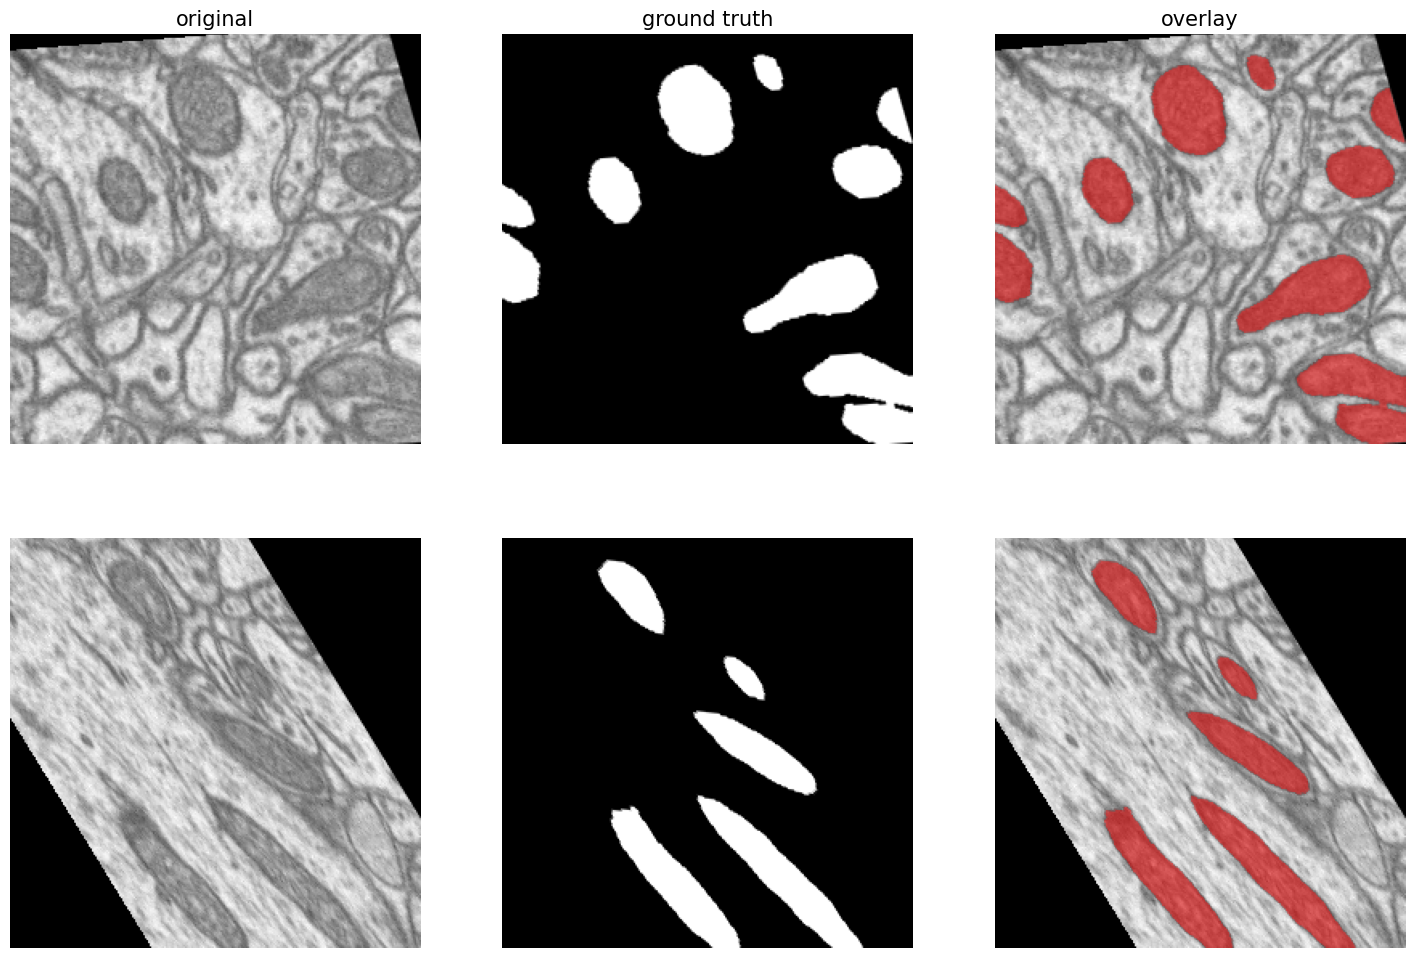

In [36]:
# Run the following code to visualize augmented examples.
sample_batch = next(train_gen)
xx, yy = sample_batch
print(xx.shape, yy.shape)
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=xx, mask_imgs=yy, nm_img_to_plot=2, figsize=6)

In [37]:
#
# Now, we set up a U-Net classifier.
#
from keras_unet.models import custom_unet

model = custom_unet(
    X_train[0].shape,
    use_batch_norm=False,
    num_classes=1,
    filters=64,
    dropout=0.2,
    output_activation='sigmoid'
)

In [38]:
# TODO: How many trainable parameters does the model use?
# TODO: YOUR_ANSWER
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 spatial_dropout2d (SpatialDrop  (None, 256, 256, 64  0          ['conv2d[0][0]']                 
 out2D)                         )                                                             

In [39]:
#
# Let's compile the model. Please use a LEARNING_RATE of 0.01
# and a MOMENTUM of 0.99.
#
LEARNING_RATE = 0.01
MOMENTUM = 0.99

In [40]:
#
# We will use Stochastic Gradient Descent as optimizer
# and use IoU as a metric.
#
from keras.optimizers import SGD
from keras_unet.metrics import iou, iou_thresholded

model.compile(
    optimizer=SGD(learning_rate=LEARNING_RATE, momentum=MOMENTUM),
    loss='binary_crossentropy',
    metrics=[iou, iou_thresholded]
)

In [41]:
# TODO: Please explain Intersect-over-Union (IoU) in just a few sentences.
# TODO: YOUR_ANSWER

IoU is a number ranging from 0 to 1 which specifies the amount of overlap between the predicted and ground truth bounding box.Intersection over Union (IoU) is used while calculating Mean average position(mAP) i.e, to determine the accuracy of a set of object detections from a model when compared to ground-truth object annotations of a dataset.

In [42]:
#
# Now let's train the model for 30 epochs!
#
# TODO: Please complete the code below.
# Hint: Don't forget to use the train_gen from above as training data.
# Hint 2: Please don't forget (X_val, y_val) as validation data.
# Hint 3: steps_per_epoch should be set to all of the X_train.
# Hint 4: This will take roughly 30 minutes.
# Hint 5: If you are stuck, look through the repo of keras_unet!
#
history = model.fit(
    train_gen,                      
    steps_per_epoch=len(X_train)//2, # Calculate number of steps per epoch and while creating train_gen we set the batch_size=2 
    epochs=30,
    validation_data=(X_val, y_val)
)

Epoch 1/30
184/184 [==============================] - 81s 401ms/step - loss: 0.2468 - iou: 0.0561 - iou_thresholded: 3.9041e-04 - val_loss: 0.2264 - val_iou: 0.0951 - val_iou_thresholded: 6.0699e-06
Epoch 2/30
184/184 [==============================] - 29s 159ms/step - loss: 0.1969 - iou: 0.0858 - iou_thresholded: 1.4426e-04 - val_loss: 0.2040 - val_iou: 0.1234 - val_iou_thresholded: 6.0699e-06
Epoch 3/30
184/184 [==============================] - 30s 165ms/step - loss: 0.1878 - iou: 0.1001 - iou_thresholded: 1.6686e-04 - val_loss: 0.2068 - val_iou: 0.0929 - val_iou_thresholded: 6.0699e-06
Epoch 4/30
184/184 [==============================] - 29s 159ms/step - loss: 0.1715 - iou: 0.1430 - iou_thresholded: 0.0857 - val_loss: 0.2041 - val_iou: 0.0874 - val_iou_thresholded: 6.0699e-06
Epoch 5/30
184/184 [==============================] - 29s 159ms/step - loss: 0.1479 - iou: 0.2019 - iou_thresholded: 0.2010 - val_loss: 0.1477 - val_iou: 0.3486 - val_iou_thresholded: 0.4770
Epoch 6/30
184/18

We can clearly see that for the above 30 epochs the value of IoU is always between 0 and 1.

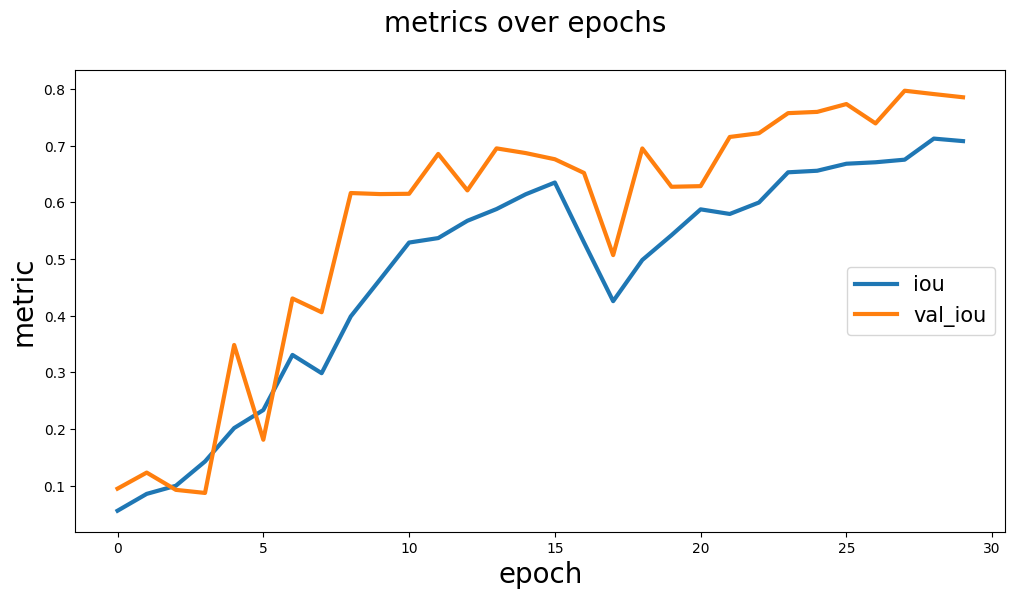

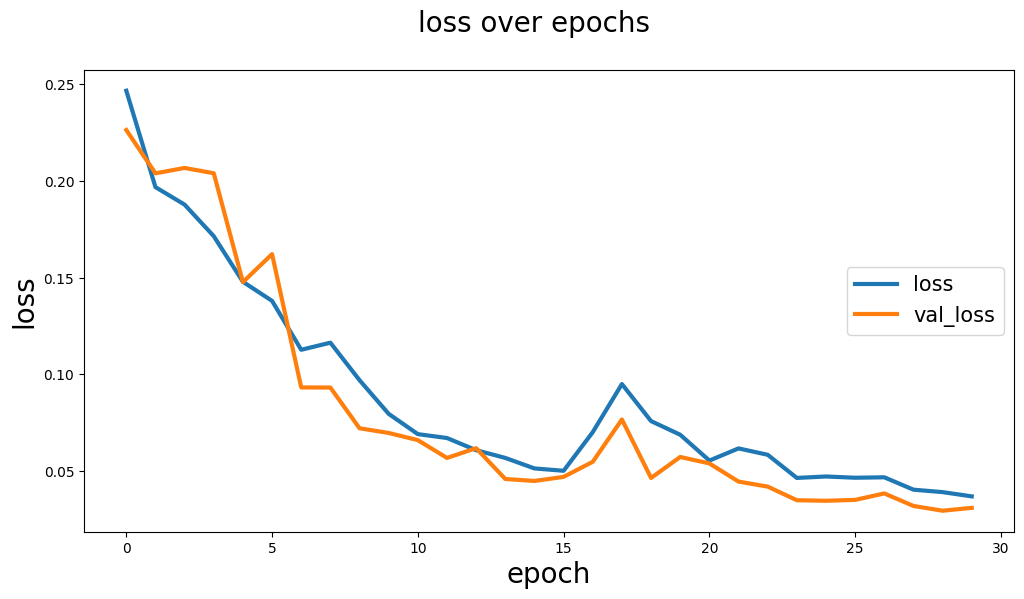

In [43]:
# We can use keras_unet functionality to visualize metrics and loss during training.
from keras_unet.utils import plot_segm_history

plot_segm_history(history)

In [44]:
# TODO: Do these plots look good to you?
# TODO: YOUR_ANSWER

Yes.They look good because both of them tend to move in the same direction but the score is not the best.

## 3. Evaluate U-Net (10 points)

In [45]:
# Let's predict all of X_test
y_pred = model.predict(X_test)

5/5 [==============================] - 4s 1s/step


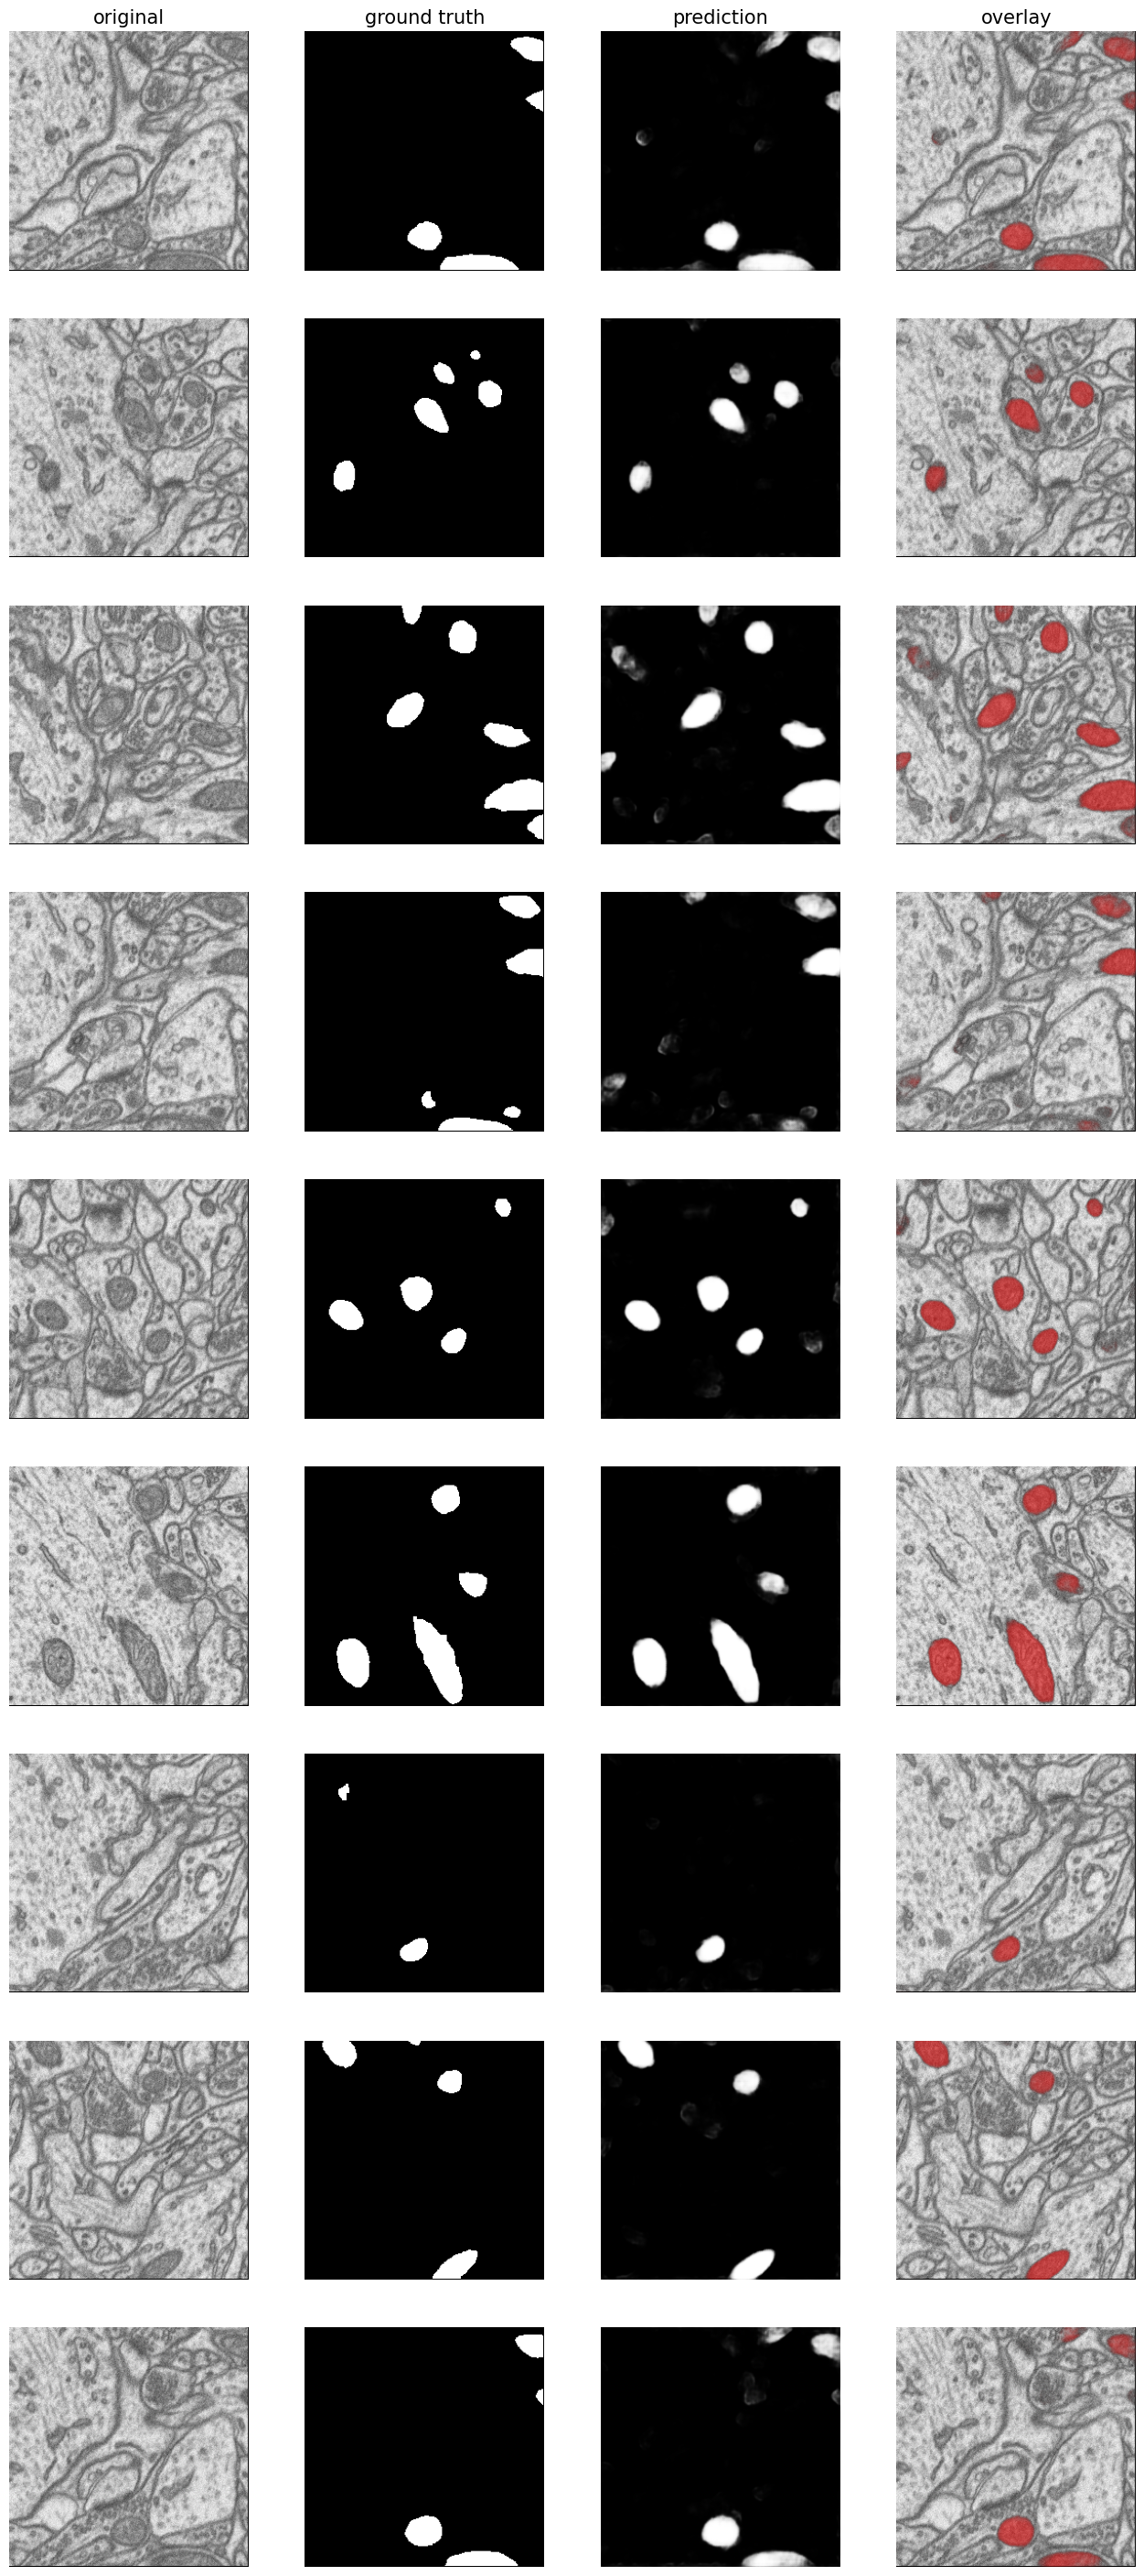

In [46]:
# ...and look at some results.
plot_imgs(org_imgs=X_test, mask_imgs=y_test, pred_imgs=y_pred, nm_img_to_plot=9)

In [47]:
import sklearn.metrics

In [48]:
# Let's use the Jaccard score to compare a thresholded
# y_pred to the groundtruth y_test.
sklearn.metrics.jaccard_score(y_test.ravel(), (y_pred > 0.5).ravel())

0.8614349982662632

In [49]:
# TODO: What is the difference between Jaccard Score and Intersect-over-Union from above?
# TODO: YOUR_ANSWER 

Jaccard score and IoU are both used to measure the accuracy of the predicted segmentation mask compared to the ground truth. Jaccard score considers the similarity between the predicted and ground truth masks as sets, while IoU considers their overlap as regions.

In [50]:
# TODO: Did the U-Net perform well on X_test?
# TODO: YOUR_ANSWER

It worked good on the X_test because the jaccard score of X_test is around 81.9%

## 4. Combine U-Net with SAM (10 points)

In [51]:
# Instead of running SAM in auto mode without seeds (Task 1), we will now
# use the U-Net predictions on X_test to seed the SAM model.

In [52]:
# We can use the following convenience functions
# to 1) convert mahotas bounding boxes to SAM format
# and 2) combine the SAM output tensors to a mask.

In [53]:
def mahotas_bbox_to_sam(bbs):

  new_bbs = []

  for i,bb in enumerate(bbs):
    # from (y1, y2, x1, x2)
    # to (x1, y1, x2, y2)
    if i == 0:
      continue
    new_bb = [bb[2], bb[0], bb[3], bb[1]]
    new_bbs.append(new_bb)

  return new_bbs

In [54]:
def sam_to_mask(results):

  results = results.cpu() # copy back to cpu land

  mask = np.array(results[0,0])

  for s in results:
    mask[s[0] == 1] = 1

  return mask

In [55]:
# The following code combines the U-Net predictions with SAM.
#
# TODO: Please study the code and answer the TODOs in-line.

In [56]:
y_pred_sam = y_pred.copy()
y_pred_sam[:] = 0

for z,img in enumerate(X_test):

  # TODO: EXPLAIN CODE BELOW
  #Saves the image as 'test.png'. 
  #and then scaled to the range [0, 255] and cast to the uint8 data type
  mh.imsave('test.png', (img[:,:,0]*255).astype(np.uint8))

  # TODO: EXPLAIN CODE BELOW
  #It sets pred to be a binary mask for the current image based on the predicted probabilities in y_pred[z].
  pred = (y_pred[z] > 0.5)

  # TODO: EXPLAIN CODE BELOW
  #This is used to label the connected components in the binary mask pred.
  #The function returns a tuple containing the labeled image and the number of labels, here the second value is ignored with the "'_"syntax.
  pred, _ = mh.labeled.label(pred)
  
  # TODO: EXPLAIN CODE BELOW
  #It computes the bounding boxes for the connected components in the labeled image pred. 
  bbs = mh.labeled.bbox(pred)

  # TODO: EXPLAIN CODE BELOW
  #This calls a custom function mahotas_bbox_to_sam() to convert the bounding boxes in bbs from the format returned by mahotas to a format which is expected by the model SegManualMaskPredictor.
  #The function returns a list of dictionaries.
  bbs_converted = mahotas_bbox_to_sam(bbs)

  # TODO: EXPLAIN CODE BELOW
  #This makes a prediction on the current image using the SegManualMaskPredictor Model using the defined parameters below i.e, source,model_type etc.
  
  results = SegManualMaskPredictor().image_predict(
      source="test.png",
      model_type="vit_l", # vit_l, vit_h, vit_b
      input_box=bbs_converted, 
      multimask_output=False,
      random_color=False,
      show=False,
      save=False,
  )

  # TODO: EXPLAIN CODE BELOW
  #it converts the output of SAM prediction to a binary mask
  sam_and_unet_pred = sam_to_mask(results)

  # TODO: EXPLAIN CODE BELOW
  #here the resulting binary mask is assigned to the appropriate location in the y_pred_sam array. 
  #it is assigned to the zth index of the first channel of the y_pred_sam array since there is only one channel in this case. 
  #This process is repeated for each image in the test set.
  y_pred_sam[z,:,:,0] = sam_and_unet_pred

vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l mo

## 5. Compare U-Net vs. U-Net+SAM. (10 points)

In [57]:
# U-Net performance on X_test (from Task 3)
sklearn.metrics.jaccard_score(y_test.ravel(), (y_pred > 0.5).ravel())

0.8614349982662632

In [58]:
# U-Net + SAM performance on X_test
sklearn.metrics.jaccard_score(y_test.ravel(), y_pred_sam.ravel())

0.8449413435725462

In [59]:
# TODO: Please explain the results - is U-Net+SAM a good addition?
# TODO: YOUR_ANSWER

In this case it doesn't look like it is a good addition because the jaccard score has dropped a bit when we combine U-Net with SAM.

## Bonus: Improve the results. (33 points)

In [60]:
# Please improve the results of U-Net+SAM and show the improved Jaccard score.

In [66]:
y_pred_sam = y_pred.copy()
y_pred_sam[:] = 0

for z,img in enumerate(X_test):

  mh.imsave('test.png', (img[:,:,0]*255).astype(np.uint8))

  pred = (y_pred[z] > 0.75)

  pred, _ = mh.labeled.label(pred)
  
  bbs = mh.labeled.bbox(pred)

  bbs_converted = mahotas_bbox_to_sam(bbs)

  results = SegManualMaskPredictor().image_predict(
      source="test.png",
      model_type="vit_l", # vit_l, vit_h, vit_b
      input_box=bbs_converted, 
      multimask_output=False,
      random_color=False,
      show=False,
      save=False,
  )

  sam_and_unet_pred = sam_to_mask(results)

  y_pred_sam[z,:,:,0] = sam_and_unet_pred

vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l mo

In [67]:
sklearn.metrics.jaccard_score(y_test.ravel(), y_pred_sam.ravel())

0.8516686984274784

In [61]:
#
# You made it!!
#
#                 _ ___                /^^\ /^\  /^^\_
#     _          _@)@) \            ,,/ '` ~ `'~~ ', `\.
#   _/o\_ _ _ _/~`.`...'~\        ./~~..,'`','',.,' '  ~:
#  / `,'.~,~.~  .   , . , ~|,   ,/ .,' , ,. .. ,,.   `,  ~\_
# ( ' _' _ '_` _  '  .    , `\_/ .' ..' '  `  `   `..  `,   \_
#  ~V~ V~ V~ V~ ~\ `   ' .  '    , ' .,.,''`.,.''`.,.``. ',   \_
#   _/\ /\ /\ /\_/, . ' ,   `_/~\_ .' .,. ,, , _/~\_ `. `. '.,  \_
#  < ~ ~ '~`'~'`, .,  .   `_: ::: \_ '      `_/ ::: \_ `.,' . ',  \_
#   \ ' `_  '`_    _    ',/ _::_::_ \ _    _/ _::_::_ \   `.,'.,`., \-,-,-,_,_,
#    `'~~ `'~~ `'~~ `'~~  \(_)(_)(_)/  `~~' \(_)(_)(_)/ ~'`\_.._,._,'_;_;_;_;_;
#